In [1]:
from data_clean import data_prepare
import scipy.stats as sps
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

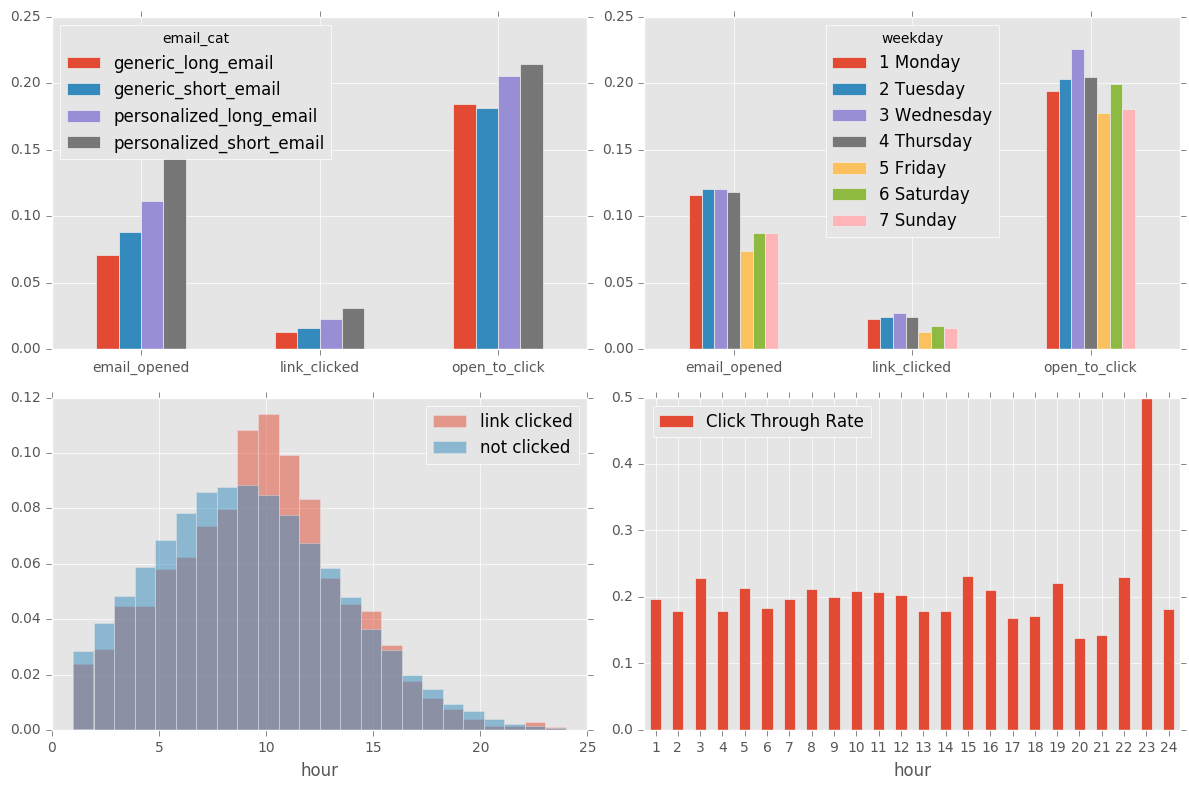

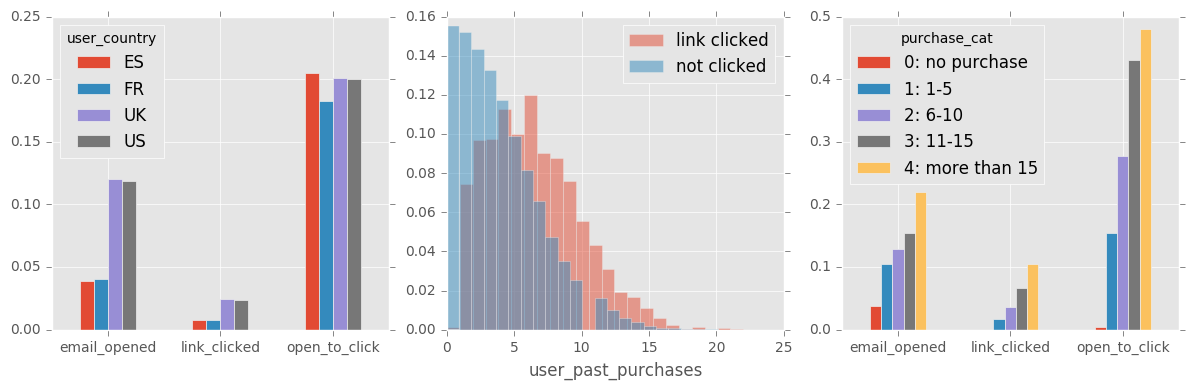

In [3]:
cols_cat = ['email_text', 'email_version', 'weekday',
            'user_past_purchases', 'hour', 'user_country']
df = data_prepare()

In [4]:
df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_opened,link_clicked,email_cat,purchase_cat,ES,FR,UK,US
0,85120.0,1,1,2.0,7,0,5.0,0.0,0.0,3,1,0,0,0,1
1,966622.0,0,1,12.0,7,1,2.0,1.0,1.0,2,1,0,0,1,0
2,777221.0,0,1,11.0,3,0,2.0,0.0,0.0,2,1,0,0,0,1
3,493711.0,1,0,6.0,1,1,1.0,0.0,0.0,1,1,0,0,1,0
4,106887.0,0,0,14.0,1,0,6.0,0.0,0.0,0,2,0,0,0,1


In [17]:
def choose_user(df):
    '''
    Without running a ML model, choose the user group of higher possibility
    '''
    choose, opened, clicked = 0, 0, 0
    for row in df.iterrows():
        row = row[1]
        if ((row['email_text'] == 1)
            and (row['email_version'] == 1)
            and (8<=row['hour']<=14)
            and (row['weekday']<=4)
            and (row['user_past_purchases'] > 0)
            and (row['user_country'] <= 1)
           ):
            choose += 1
            if row['email_opened'] == 1:
                opened += 1
            if row['link_clicked'] == 1:
                clicked += 1
    print 'The result of choose user by eda withou ML:'
    print '{}% of email opened'.format(round((opened*1.0 / choose * 100), 2))
    print '{}% of link clicked'.format(round((clicked*1.0 / choose * 100), 2))
choose_user(df)

The result of choose user by eda withou ML:
22.73% of email opened
5.21% of link clicked


In [46]:
from xgboost import XGBClassifier

In [40]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [19]:
cols_cat = ['email_text', 'email_version', 'weekday',
            'user_past_purchases', 'hour', 'user_country']
X = df[cols_cat].values
y = df['email_opened'].values

In [20]:
X_sampled.shape

(44828, 6)

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [165]:
def cv_model(X, y, clf, smp, **kwclf):
    kf = KFold(n_splits=5)
    acc, pre, rec, f1 = 0, 0, 0, 0
    for train_idx, cross_idx in kf.split(X):
        X_t, y_t = X[train_idx], y[train_idx]
        X_c, y_c = X[cross_idx], y[cross_idx]
        X_sampled, y_sampled = smp(ratio=0.5).fit_sample(X_t, y_t)
        mod = clf(**kwclf).fit(X_sampled, y_sampled)
        y_p = mod.predict(X_c)
        acc += accuracy_score(y_c, y_p)
        pre += precision_score(y_c, y_p)
        rec += recall_score(y_c, y_p)
        f1 += f1_score(y_c, y_p)
    print 'CV accuracy :{} precision:{}'\
           'recall:{} f1:{}'.format(round(acc/5, 3), round(pre/5, 3),
                                      round(rec/5, 3), round(f1/5, 3))
cv_model(X, y, RandomForestClassifier, RandomUnderSampler, **{'n_estimators':200})

CV accuracy :0.712 precision:0.143recall:0.358 f1:0.205


In [140]:
cv_model(X, y, RandomForestClassifier, SMOTE, **{'n_estimators':200})

CV accuracy :0.816468234117	 precision: 0.15169110433	recall: 0.168400429922	f1: 0.15955083078



In [142]:
cv_model(X, y, GaussianNB, RandomUnderSampler)

CV accuracy :0.509504752376	 precision: 0.141755200976	recall: 0.739667266608	f1: 0.23790191061



In [144]:
cv_model(X, y, GaussianNB, SMOTE)

CV accuracy :0.510575287644	 precision: 0.14128252042	recall: 0.734071348155	f1: 0.236939257447



In [43]:
X_2 = df[df['email_opened'] == 1][cols_cat].values
y_2 = df[df['email_opened'] == 1]['link_clicked'].values

In [145]:
cv_model(X_2, y_2, RandomForestClassifier, RandomUnderSampler, **{'n_estimators':200})

CV accuracy :0.543644272595	 precision: 0.241433312077	recall: 0.59871432938	f1: 0.343992706221



In [86]:
cv_model(X_2, y_2, GaussianNB(), SMOTE())

725.0 427.0 2069
0.64813919768 0.292413793103 0.496487119438 0.368055555556
692.0 395.0 2069
0.669888835186 0.291907514451 0.511392405063 0.371665133395
703.0 430.0 2069
0.660222329628 0.305832147937 0.5 0.379523389232
689.0 407.0 2069
0.652005799903 0.272859216255 0.461916461916 0.343065693431
695.0 410.0 2069
0.676655389077 0.313669064748 0.531707317073 0.394570135747


In [87]:
smp = RandomUnderSampler()
clf = XGBClassifier(n_estimators=200)
cv_model(X, y, clf, smp)

9469.0 2024.0 19990
0.569834917459 0.152814447143 0.714920948617 0.251805446794
9404.0 2122.0 19990
0.574187093547 0.16025095704 0.710179076343 0.261495748742
9203.0 2055.0 19990
0.578489244622 0.153862870803 0.689051094891 0.251554450169
9225.0 2052.0 19990
0.57663831916 0.152520325203 0.68567251462 0.249534450652
9239.0 2092.0 19990
0.577738869435 0.156402208031 0.690726577438 0.255052510811


In [88]:
smp = RandomUnderSampler()
clf = XGBClassifier(n_estimators=200)
cv_model(X_2, y_2, clf, smp)

919.0 427.0 2069
0.594006766554 0.275299238303 0.592505854801 0.375928677563
972.0 395.0 2069
0.584823586274 0.261316872428 0.643037974684 0.371616678859
899.0 430.0 2069
0.599323344611 0.27808676307 0.581395348837 0.376222723853
907.0 407.0 2069
0.588206863219 0.254685777288 0.567567567568 0.351598173516
973.0 410.0 2069
0.584823586274 0.269270298047 0.639024390244 0.37888647867


In [159]:
def hour_prob():
    '''
    make probalbility list for hour, with a bimodal normal distribution
    '''
    a = sps.norm(12, 4)
    b = sps.norm(23, 3)
    x = range(1, 30)
    p = 3 * a.pdf(x) + b.pdf(x)
    p = list(p[23:28]) + list(p[4: 23])
    p = np.array(p) / sum(p)
    return p


def generate_sim_data(size=20000):
    '''
    Make simulation data by the strategy discribed
    '''
    email_text = np.random.binomial(1, 1, size)
    email_ver = np.random.binomial(1, 1, size)
    p_hour = hour_prob()
    p_purchase = sps.norm(12, 5).pdf(range(0, 23))
    p_purchase = p_purchase / p_purchase.sum()
    p_weekday = sps.norm(3, 4).pdf(range(1, 8))
    p_weekday = p_weekday/p_weekday.sum()
    hour = np.random.choice(range(1, 25), size, p=p_hour)
    purchase = np.random.choice(range(0, 23), size, p=p_purchase)
    weekday = np.random.choice(range(1, 8), size, p=p_weekday)
    country = np.random.choice(range(4), size, p=[0.7, 0.2, 0.05, 0.05])
    data = np.stack([email_text, email_ver, weekday, purchase, hour, country])
    return data.T

def prediction_model(df, clf, smp, **kwclf):
    '''
    Build prediction model for email open and link click
    '''
    cols_cat = ['email_text', 'email_version', 'weekday',
                'user_past_purchases', 'hour', 'user_country']
    X_1 = df[cols_cat].values
    y_1 = df['email_opened'].values
    print '-'*30
    print 'stage 1'
    cv_model(X_1, y_1, clf, smp, **kwclf)
    X_1, y_1 = smp(ratio=0.5).fit_sample(X_1, y_1)
    clf_1 = clf(**kwclf)
    clf_1.fit(X_1, y_1)
    X_2 = df[df['email_opened'] == 1][cols_cat].values
    y_2 = df[df['email_opened'] == 1]['link_clicked'].values
    print '\nstage 2'
    cv_model(X_2, y_2, clf, smp, **kwclf)
    X_2, y_2 = smp(ratio=0.5).fit_sample(X_2, y_2)
    clf_2 = clf(**kwclf)
    clf_2.fit(X_2, y_2)
    return clf_1, clf_2

def run_simulation(df, n_times, n_size,  clf, smp, **kwclf):
    clf_1, clf_2 = prediction_model(df, clf, smp, **kwclf)
    score_1, score_2 = 0, 0
    for i in range(n_times):
        X_sim = generate_sim_data(n_size)
        y_pred_1 = clf_1.predict(X_sim)
        y_pred_2 = clf_2.predict(X_sim[y_pred_1 == 1])
        score_1 += y_pred_1.sum() / len(y_pred_1)
        score_2 += y_pred_2.sum() / len(y_pred_2)
    score_1 /= n_times
    score_2 /= n_times
    print '-'*30
    print 'Simulation result:'
    print 'Average email open rate: {}%'.format(round(score_1*100, 2))
    print 'Average open to click rate: {}%'.format(round(score_2*100, 2))
run_simulation(df, 5, 100000, GaussianNB, RandomUnderSampler)

------------------------------
stage 1
CV accuracy :0.809414707354	 precision: 0.190135205891	recall: 0.25805058823	f1: 0.21877330199

stage 2
CV accuracy :0.776607056549	 precision: 0.395840398192	recall: 0.219541075535	f1: 0.281826182478
------------------------------
Simulation result:
Average email open rate: 83.31%
Average open to click rate: 81.96%


------------------------------
Simulation result:
Average email open rate: 31.97%
Average click through rate: 18.27%
